In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import random
!pip install wget
from random import sample

from os import path
import h5py
import keras.backend as K
import wget

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, AveragePooling2D, Dropout, Conv2DTranspose, SeparableConv2D, Add
from keras.models import Model
from keras import backend as K
from tensorflow.keras import datasets, layers, losses

In [ ]:

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = np.reshape(train_images, (len(train_images), 28, 28, 1))
test_images = np.reshape(test_images, (len(test_images), 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:

def my_model():
  input_img = Input(shape=(28, 28, 1))
  num_filter = 28
  kernel_size = 5
  strides = 1   
  
  x = Conv2D(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'enc1')(input_img)

  x = Conv2D(1, kernel_size, strides, activation='relu', padding='same', name = 'enc2')(x) 

  x = AveragePooling2D((2, 2))(x)

  # x = Conv2D(1, kernel_size, strides, activation='relu', padding='same', name = 'enc4')(x) 
  # x = AveragePooling2D((2, 2))(x)   

  encoded = BatchNormalization()(x)
  

  x = UpSampling2D((2,2), interpolation = 'bilinear')(encoded)
  x = Conv2DTranspose(1, kernel_size, strides, activation='relu', padding='same', name = 'dec1')(x)

  # x = UpSampling2D((2,2), interpolation = 'bilinear')(x)        
  # x = Conv2DTranspose(1, kernel_size, strides, activation='relu', padding='same', name = 'dec2')(x) 
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'dec4')(x)
  # x = BatchNormalization()(x) 
  decoded = Conv2D(1,(1, 1), activation='sigmoid', name = 'output')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  return autoencoder

autoencoder = my_model()

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
enc1 (Conv2D)                (None, 28, 28, 28)        728       
_________________________________________________________________
enc2 (Conv2D)                (None, 28, 28, 1)         701       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 1)         4         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 1)         0         
_________________________________________________________________
dec1 (Conv2DTranspose)       (None, 28, 28, 1)         26  

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

checkpoint = ModelCheckpoint('models\\modelmnist-best.h5',
                                  verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

autoencoder.fit(train_images, train_images,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images),
                callbacks = [es, checkpoint]
                )

del autoencoder  # deletes the existing model
autoencoder = load_model('models\\modelmnist-best.h5')

Epoch 1/200
235/235 [==============================] - 4s 12ms/step - loss: 0.1147 - val_loss: 0.1212
Epoch 2/200
235/235 [==============================] - 2s 10ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 3/200
235/235 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/200
235/235 [==============================] - 2s 11ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/200
235/235 [==============================] - 3s 11ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/200
235/235 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/200
235/235 [==============================] - 2s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/200
235/235 [==============================] - 2s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/200
235/235 [==============================] - 2s 10ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/200
235/235 [==============================] - 2s 10ms/step - loss: 0.001

In [ ]:
predicted_test = autoencoder.predict(test_images[:100])
predicted_test = np.clip(predicted_test, 0., 1.)
print(test_images[1].shape)
print(predicted_test[1].shape)

(28, 28, 1)
(28, 28, 1)


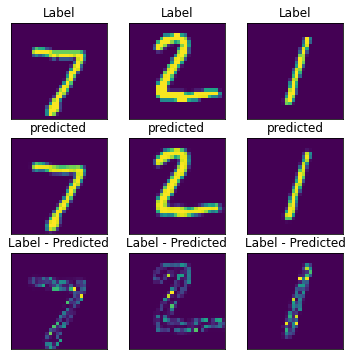

In [ ]:
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("predicted")
    plt.imshow(tf.squeeze((predicted_test[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_test[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
psnr_pred = tf.image.psnr(predicted_test, test_images[:100], max_val=1.0)
print('PSNR: ', np.mean(psnr_pred))

PSNR:  30.756079


In [ ]:
noise_factor_uniform = 0.4
noise_factor_normal = 0.25

x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)

x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)


In [ ]:
predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])

predicted_uniform = np.clip(predicted_uniform, 0., 1.)
predicted_normal = np.clip(predicted_normal, 0., 1.)


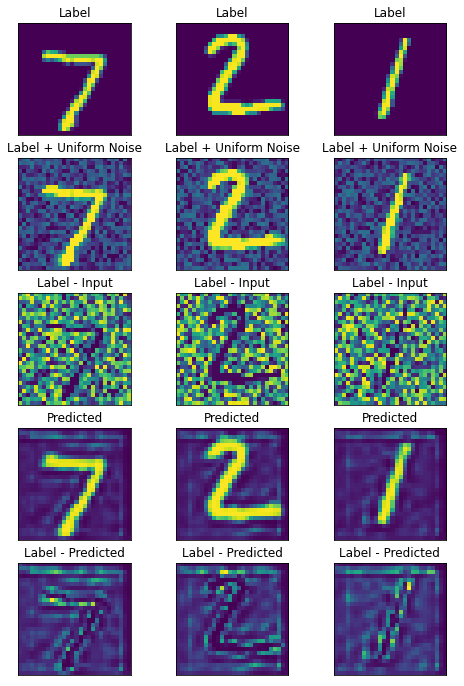

In [ ]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Uniform Noise")
    plt.imshow(tf.squeeze((x_test_noisy_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_uniform[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_uniform[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

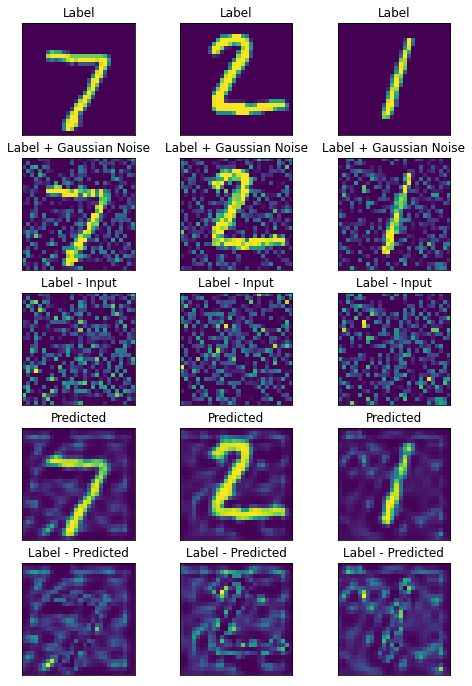

In [ ]:

n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Gaussian Noise")
    plt.imshow(tf.squeeze((x_test_noisy_normal[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_normal[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_normal[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_normal[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))


Uniform:  13.137334 16.998438
Gaussian:  14.812475 18.468376


In [ ]:
def calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,autoencoder):
  x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
  x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
  
  x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
  x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)

  predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
  predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
  
  predicted_uniform = np.clip(predicted_uniform, 0., 1.)
  predicted_normal = np.clip(predicted_normal, 0., 1.)

  psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
  psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

  psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
  psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

  print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
  print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))

  return np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred), np.mean(psnr_normal_input), np.mean(psnr_normal_pred)

In [ ]:

# print('----')
# noise_factor_uniform = 0.74
# noise_factor_normal = 0.5
# noise_factor_speckle = 2.8
# calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder)
PSNR_Results = []
for i in range(0,20):
  noise_factor_uniform = i*0.035
  noise_factor_normal = i*0.025
  
  PSNR_Results.append(calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,autoencoder))
  print('----')

PSNR_Results = np.asarray(PSNR_Results)

Uniform:  inf 30.756079
Gaussian:  inf 30.756079
----
Uniform:  34.135025 29.397215
Gaussian:  34.584156 30.042725
----
Uniform:  28.202208 25.775454
Gaussian:  28.62774 27.995943
----
Uniform:  24.676304 24.074926
Gaussian:  25.144611 26.020226
----
Uniform:  22.164593 22.948402
Gaussian:  22.65054 24.380335
----
Uniform:  20.24975 22.051338
Gaussian:  20.765047 23.143581
----
Uniform:  18.682625 21.194117
Gaussian:  19.195704 21.989233
----
Uniform:  17.371593 20.429976
Gaussian:  17.883064 21.031775
----
Uniform:  16.228117 19.6237
Gaussian:  16.763718 20.070244
----
Uniform:  15.220237 18.865679
Gaussian:  15.769695 19.199549
----
Uniform:  14.326887 18.08645
Gaussian:  14.886827 18.457281
----
Uniform:  13.478238 17.34003
Gaussian:  14.080048 17.692812
----
Uniform:  12.725619 16.613894
Gaussian:  13.36435 16.936361
----
Uniform:  12.036322 15.877673
Gaussian:  12.711623 16.246243
----
Uniform:  11.414574 15.15927
Gaussian:  12.016825 15.562303
----
Uniform:  10.8092165 14.477173


In [ ]:

from scipy.io import savemat

savemat('Noisy_AE_PSNR_Results_MNIST_4x.mat',{'PSNR_Results':PSNR_Results})

from google.colab import files
files.download("Noisy_AE_PSNR_Results_MNIST_4x.mat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(AE-NCC for 2x compression)

[link text](https://github.com/Alishba18001778/Codes/blob/main/AE_MNIST_2x.png//)




AE-NCC for 4x compression
[link text](https://github.com/Alishba18001778/Codes/blob/main/AE_MNIST_4x.png//)